In [2]:
import json
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import data_access as da

In [3]:
model_names = da.list_model_names()

In [4]:
def round_to_quarter(x):
    return math.ceil(x*4)/4

In [23]:
def create_df(sample_names, model_names, modes, error_side=False):
    if sample_names == 'all':
        sample_names = da.list_sample_names()
    if model_names == 'all':
        model_names = da.list_model_names()
    if modes == 'all':
        modes = ['greedy', 'lm+fst']
    data = []
    for mode in modes:
        for sample_name in sample_names:
            for model_name in model_names:
                result = da.get_eval_results(sample_name, model_name, mode)
                for i, word in enumerate(result):
                    if error_side:
                        data.append((sample_name, i, word['ae_start'], 'start', mode))
                        data.append((sample_name, i, word['ae_end'], 'end', mode))
                    else:
                        data.append((sample_name, i, np.mean([word['ae_start'], word['ae_end']]), mode, model_name))
    columns = ['sample_name', 'word_index', 'error MAE', 'error_side', 'mode', 'model_name']
    if not error_side:
        columns.remove('error_side')
    df = pd.DataFrame(data, columns=columns)
    return df

In [10]:
def basic_bar_plot(model_name, mode, xmax=None):
    sample_names = sorted(da.list_sample_names())
    starts_e = []
    ends_e = []
    errors = []
    for sample_name in sample_names:
        result = da.get_eval_results(sample_name, model_name, mode)
        mean_start_ae = np.mean([word['ae_start'] for word in result])
        mean_end_ae = np.mean([word['ae_end'] for word in result])
        starts_e.append(mean_start_ae)
        ends_e.append(mean_end_ae)
        errors.append(0.5 *(mean_start_ae + mean_end_ae))
    df = pd.DataFrame({'sample_name': sample_names, 'errors (MAE)': errors}) 
    plt.figure(figsize=(15,11))
    sns.barplot(y='sample_name', x='errors (MAE)', data=df);
    plt.grid()
    n_ticks = 20
    xmax = xmax if xmax is not None else max(errors)
    step = round_to_quarter(xmax / n_ticks)
    plt.xticks(np.arange(0, xmax, step));
    if xmax is not None:
        plt.xlim(0, xmax)
    plt.show()

In [33]:
def all_sample_box_plot(split='mode+model', ymax=None):
    df = create_df(sample_names='all', model_names='all', modes='all')
    plt.figure(figsize=(15,11))
    if split.startswith('model'):
        hue = 'mode' if split.endswith('+mode') else None
        x = 'model_name'
    elif split.startswith('mode'):
        x = 'mode'
        hue = 'model_name' if split.endswith('+model') else None
    sns.boxplot(x=x, y='error MAE', hue=hue, data=df)
    ymax = ymax if ymax is not None else df['error MAE'].max()
    plt.ylim(-0.1, ymax)
    plt.grid()
    plt.show()
    

In [26]:
def box_plot(model_name, modes, hue=False, xmax=None):
    sample_names = sorted(da.list_sample_names())
    data = []
    modes = modes if not isinstance(modes, str) else [modes]
    for mode in modes:
        for sample_name in sample_names:
            result = da.get_eval_results(sample_name, model_name, mode)
            for i, word in enumerate(result):
                data.append((sample_name, i, word['ae_start'], 'start', mode))
                data.append((sample_name, i, word['ae_end'], 'end', mode))
    df = pd.DataFrame(data, columns=['sample_name', 'word_index', 'error MAE', 'error_side', 'mode'])
    plt.figure(figsize=(20, 15))
    if hue:
        sns.boxplot(x="error MAE", y="sample_name", hue='error_side', data=df)
    else:
        sns.boxplot(x="error MAE", y="sample_name", hue='mode', data=df)
    plt.grid()
    n_ticks = 20
    xmax = xmax if xmax is not None else df['error MAE'].max()
    step = round((xmax / n_ticks), 2)
    plt.xticks(np.arange(0, xmax, step));
    plt.xlim(-0.1, xmax)
    plt.show()

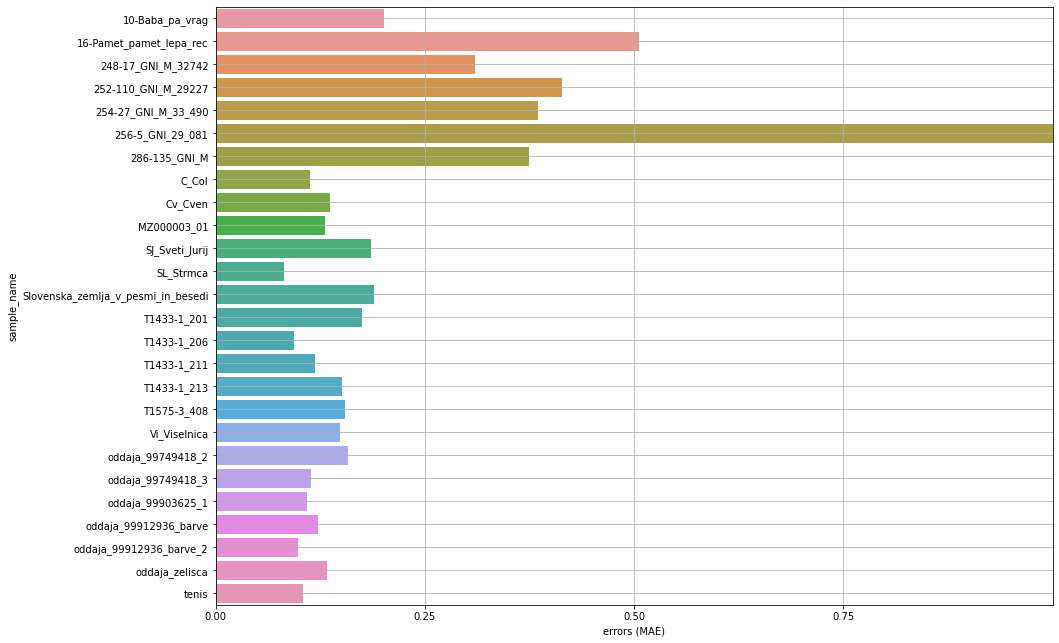

In [15]:
basic_bar_plot(model_names[0], 'lm+fst', 1)

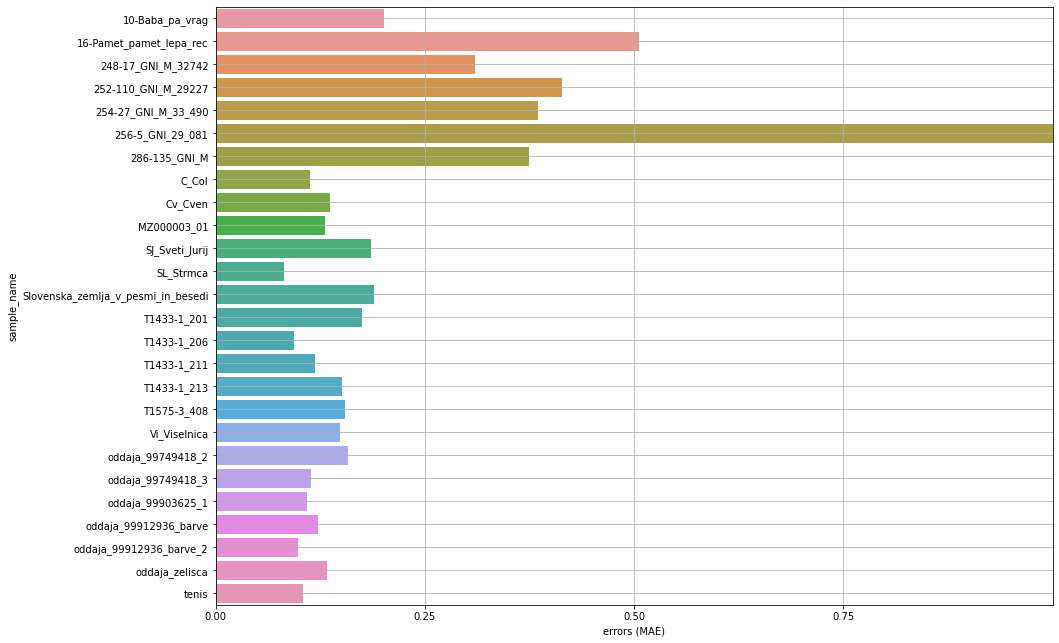

In [16]:
basic_bar_plot(model_names[0], 'lm+fst', 1)

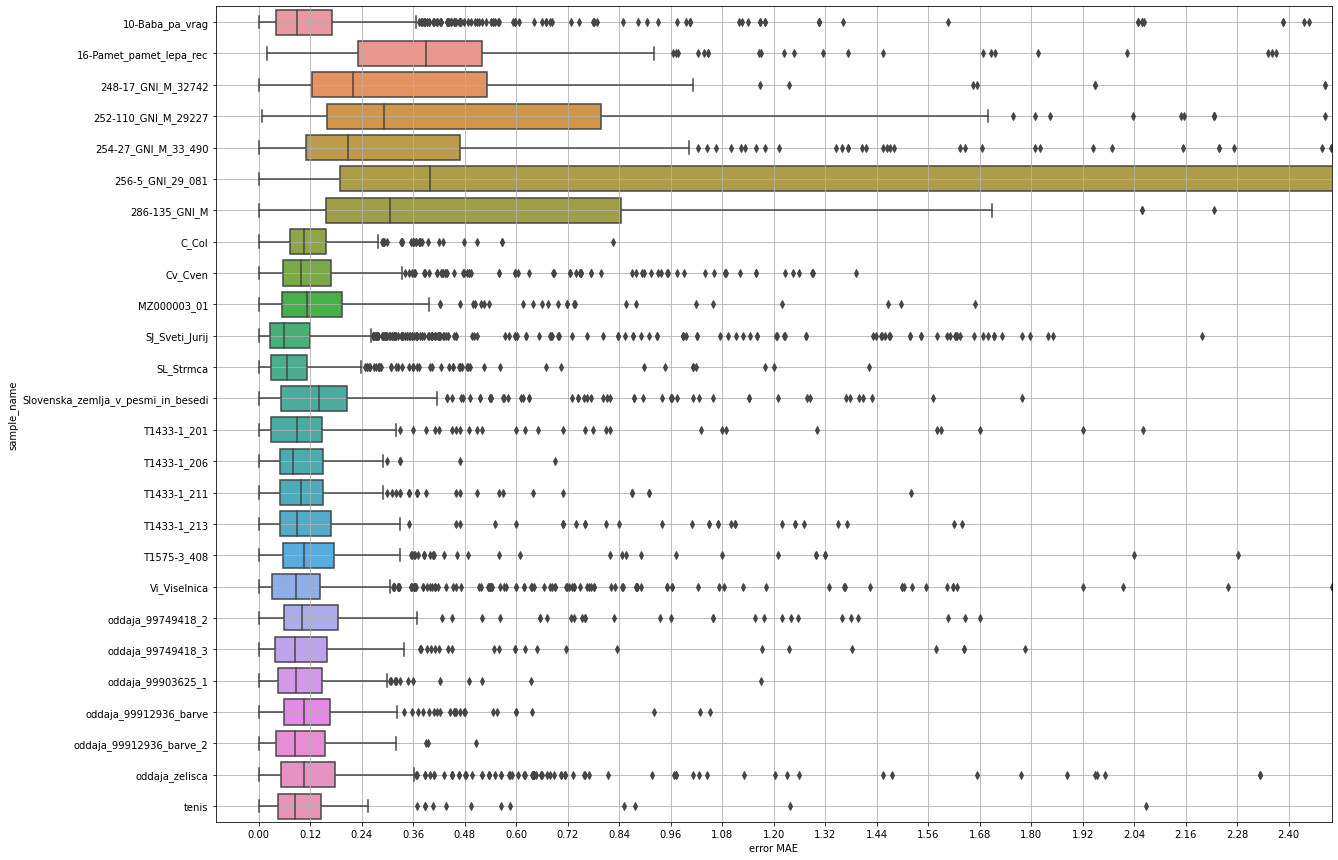

In [25]:
box_plot(model_names[0], ['greedy', 'lm+fst'], xmax=2.5)

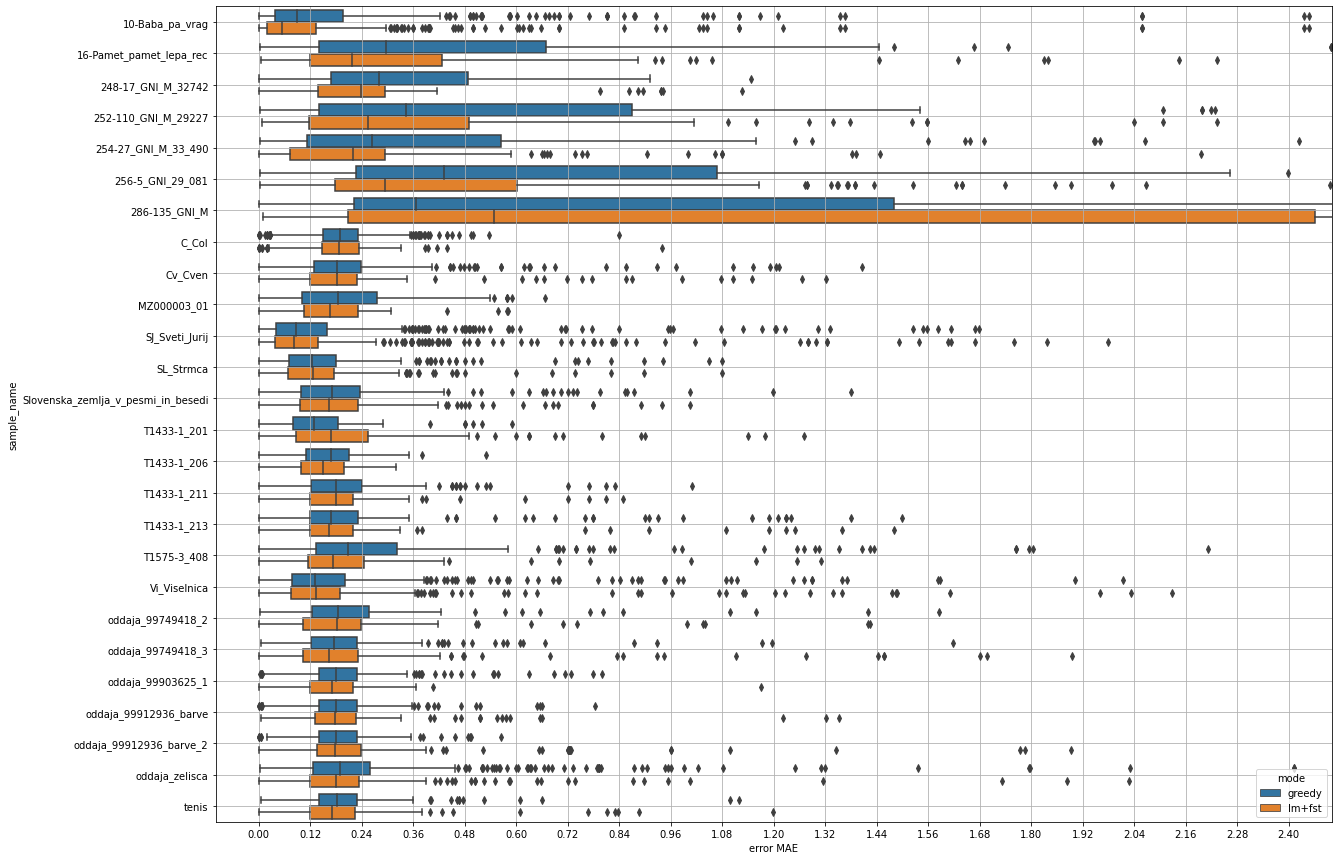

In [20]:
box_plot(model_names[1], ['greedy', 'lm+fst'], xmax=2.5)

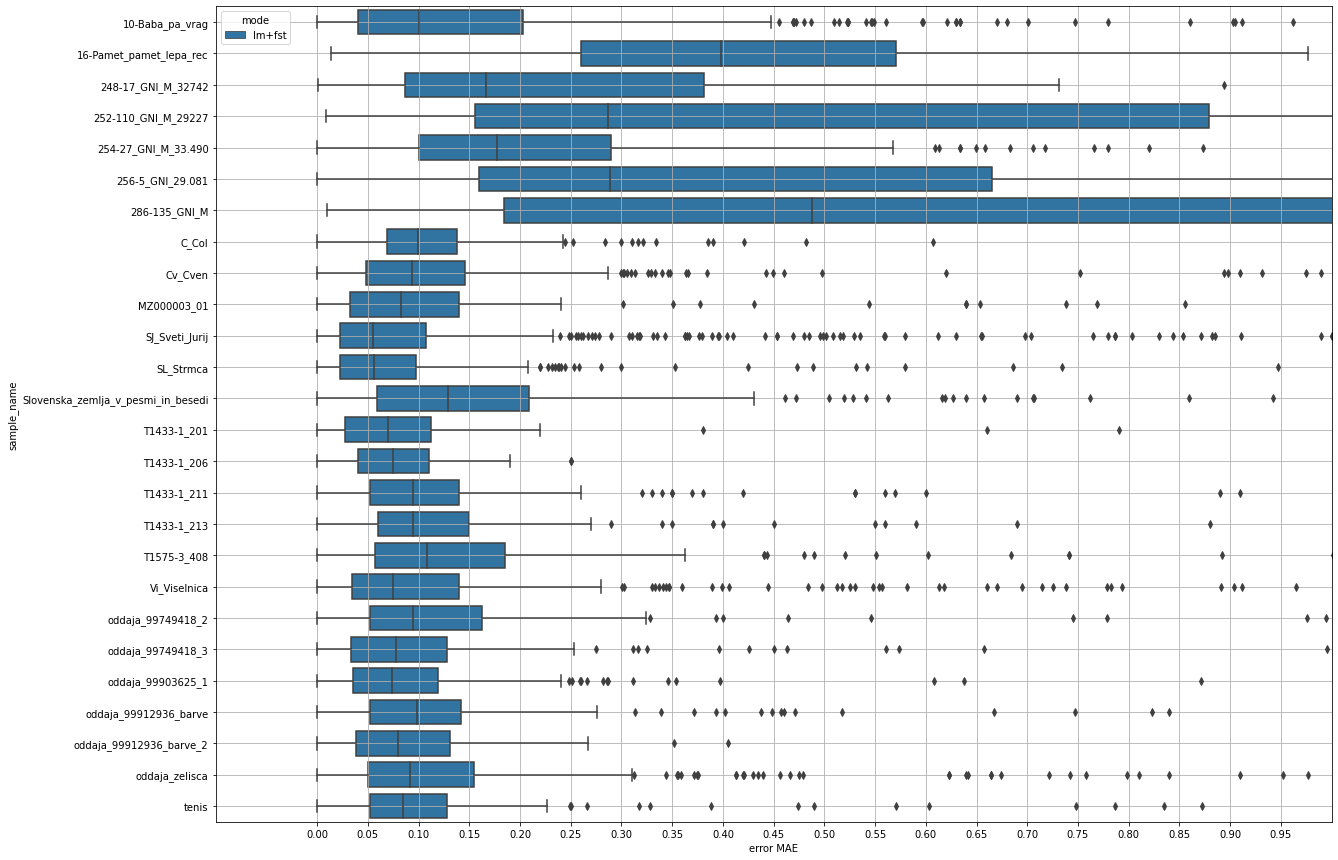

In [26]:
box_plot('lm+fst', xmax=1)

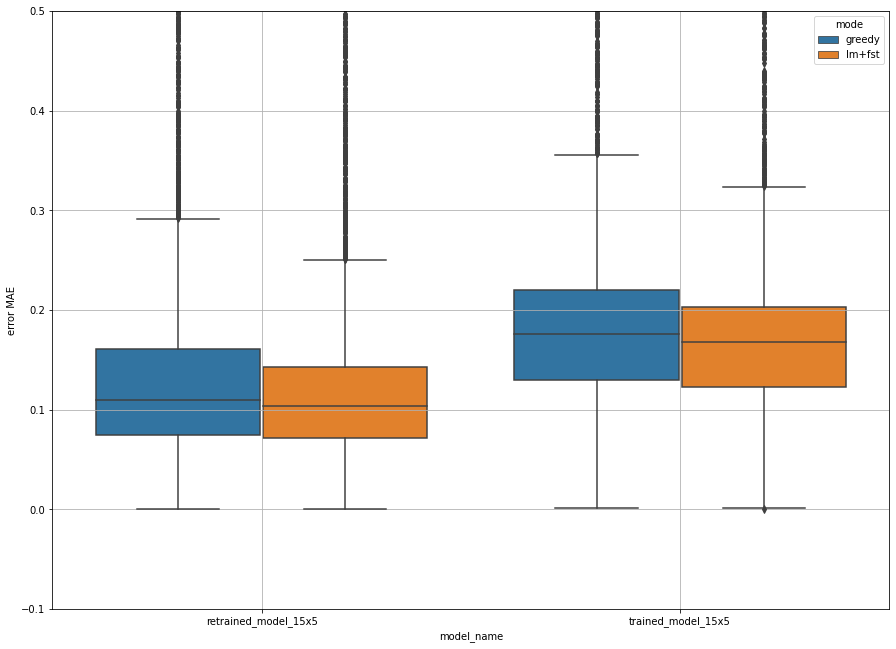

In [39]:
all_sample_box_plot(split='model+mode', ymax=0.5)